In [1]:
import astropy
from astropy.io import fits 
from astropy.stats import sigma_clip
from astropy.table import Table
from astropy.time import Time
from astropy.visualization import time_support
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal as sig
from scipy.stats import sigmaclip

In [2]:
#Goal: define 2 functions to apply to TESS data
#     1. dataClean
#      -remove nan values 
#      -remove flagged values 
#      -correct time values

#     2. flareFinder
#       -compare avg flux value of light curve to flux data
#       -if value_flux > avg flux by x(sigma), pull into new array (until equal to or less than x(sigma)) (new array for each flare?)
#       -then continue through the rest of the data
#       -find max flux in each array 
#       -pull associated timestamp from cleaned data 
#       -print timestamp, flux value for each flare discovered

In [3]:
def dataClean(filename): #Can I use the file path as an input?
    """ This function will remove nan values from TESS 
        20 second lightcurve data and correct time values"""
    
 #Create an array of time and flux data with nans removed    
    with fits.open(filename, mode="readonly") as hdulist:
        raw_time = hdulist[1].data['TIME']
        raw_flux = hdulist[1].data['PDCSAP_FLUX']
        raw_err = hdulist[1].data['PDCSAP_FLUX_ERR']
    
    data = np.vstack((raw_time, raw_flux, raw_err))
    nonan_data = data[:, ~np.isnan(data).any(axis=0)]
 #   error = np.where(np.isfinite(raw_err))
#Apply time correction and create array of corrected and cleaned data
    times = nonan_data[0]
    flux = nonan_data[1]
    error = nonan_data[2]
    t_corr = []
    for i in times:
        r = i + 2457000
        t_corr.append(r)
    time = Time(t_corr, format = 'jd', scale = 'utc')
    time.format = 'iso'
    time = np.array(time)
    flux = np.array(flux)
    err = np.array(error)
#Return cleaned data
    return[time,flux,err]

In [10]:
def flareFinder(cleaned_data, sigma_multiplier):
    """ This function will take cleaned data and a multiple to be applied to sigma. 
        The function will run through the data, creating arrays of flux values 
        when the flux is > avg flux by the specified multiple of sigma. Using the max
        flux value from each array, the corresponding time value will be pulled from
        the cleaned data set. Timestamp and max flux will be printed """
#identify quiescent light curve

    flux_smooth = sig.savgol_filter(cleaned_data[1], 1400, 3) #my opinion of the best parameters for this data
    index = np.where(cleaned_data[1] < (flux_smooth + (3*cleaned_data[2]))) #using 3 as the significance for the error for now
    q_time = cleaned_data[0][index] # time associated w/ quiescent flux
    q_flux = sig.savgol_filter(cleaned_data[1][index],2000,3) # quiescent flux
    ind2 = np.where(q_flux) #index created to assure lengths of data sets are equal
    
#set and index variables
    fluxes = cleaned_data[1]
    times = cleaned_data[0]
    F_err = cleaned_data[2] 
    flux_list = fluxes[ind2]
    time_list = times[ind2]
    err_list = F_err[ind2]

#search for flares    
    ix = np.where(flux_list > (q_flux + (sigma_multiplier*err_list)))
    flareFlux = flux_list[ix]
    flareTime = time_list[ix]
    flareTable = pd.DataFrame({
                            'Peak Time': flareTime,
                            'Peak Flux': flareFlux
    })
        
    return[flareTable]

In [11]:
TESSDATA = '/Users/katborski/Documents/GitHub/AFPSC/TESS/tess2021232031932-s0042-0000000250081915-0213-a_fast-lc.fits'
cleaned_data = dataClean(TESSDATA)

In [12]:
flareTable = flareFinder(cleaned_data,3)

In [13]:
peaks = flareTable[0]['Peak Flux']

In [14]:
sig.argrelextrema(flux_list,np.less)


NameError: name 'flux_list' is not defined

ConversionError: Failed to convert value(s) to axis units: array([<Time object: scale='utc' format='iso' value=2021-08-21 04:56:35.476>,
       <Time object: scale='utc' format='iso' value=2021-08-21 05:15:15.525>,
       <Time object: scale='utc' format='iso' value=2021-08-21 10:30:16.318>,
       <Time object: scale='utc' format='iso' value=2021-08-21 10:31:36.322>,
       <Time object: scale='utc' format='iso' value=2021-08-21 10:40:36.344>,
       <Time object: scale='utc' format='iso' value=2021-08-21 13:57:16.824>,
       <Time object: scale='utc' format='iso' value=2021-08-21 14:33:56.912>,
       <Time object: scale='utc' format='iso' value=2021-08-21 20:25:37.744>,
       <Time object: scale='utc' format='iso' value=2021-08-21 20:31:17.757>,
       <Time object: scale='utc' format='iso' value=2021-08-21 21:15:37.860>,
       <Time object: scale='utc' format='iso' value=2021-08-21 21:55:37.953>,
       <Time object: scale='utc' format='iso' value=2021-08-21 22:42:18.060>,
       <Time object: scale='utc' format='iso' value=2021-08-22 01:52:58.496>,
       <Time object: scale='utc' format='iso' value=2021-08-22 01:56:38.504>,
       <Time object: scale='utc' format='iso' value=2021-08-22 02:50:18.626>,
       <Time object: scale='utc' format='iso' value=2021-08-22 03:20:18.693>,
       <Time object: scale='utc' format='iso' value=2021-08-22 05:49:39.028>,
       <Time object: scale='utc' format='iso' value=2021-08-22 06:25:39.108>,
       <Time object: scale='utc' format='iso' value=2021-08-22 06:25:59.109>,
       <Time object: scale='utc' format='iso' value=2021-08-22 06:26:19.110>,
       <Time object: scale='utc' format='iso' value=2021-08-22 06:26:39.111>,
       <Time object: scale='utc' format='iso' value=2021-08-22 06:26:59.111>,
       <Time object: scale='utc' format='iso' value=2021-08-22 06:27:19.112>,
       <Time object: scale='utc' format='iso' value=2021-08-22 06:27:39.113>,
       <Time object: scale='utc' format='iso' value=2021-08-22 06:27:59.114>,
       <Time object: scale='utc' format='iso' value=2021-08-22 06:28:19.114>,
       <Time object: scale='utc' format='iso' value=2021-08-22 06:28:39.115>,
       <Time object: scale='utc' format='iso' value=2021-08-22 06:28:59.116>,
       <Time object: scale='utc' format='iso' value=2021-08-22 06:29:19.117>,
       <Time object: scale='utc' format='iso' value=2021-08-22 06:29:39.117>,
       <Time object: scale='utc' format='iso' value=2021-08-22 06:29:59.118>,
       <Time object: scale='utc' format='iso' value=2021-08-22 06:30:19.119>,
       <Time object: scale='utc' format='iso' value=2021-08-22 06:30:39.120>,
       <Time object: scale='utc' format='iso' value=2021-08-22 06:30:59.120>,
       <Time object: scale='utc' format='iso' value=2021-08-22 06:31:39.122>,
       <Time object: scale='utc' format='iso' value=2021-08-22 06:31:59.122>,
       <Time object: scale='utc' format='iso' value=2021-08-22 06:32:19.123>,
       <Time object: scale='utc' format='iso' value=2021-08-22 06:32:39.124>,
       <Time object: scale='utc' format='iso' value=2021-08-22 06:32:59.125>,
       <Time object: scale='utc' format='iso' value=2021-08-22 06:33:19.125>,
       <Time object: scale='utc' format='iso' value=2021-08-22 06:33:39.126>,
       <Time object: scale='utc' format='iso' value=2021-08-22 06:33:59.127>,
       <Time object: scale='utc' format='iso' value=2021-08-22 06:34:19.128>,
       <Time object: scale='utc' format='iso' value=2021-08-22 06:34:39.128>,
       <Time object: scale='utc' format='iso' value=2021-08-22 06:34:59.129>,
       <Time object: scale='utc' format='iso' value=2021-08-22 06:35:19.130>,
       <Time object: scale='utc' format='iso' value=2021-08-22 06:35:59.131>,
       <Time object: scale='utc' format='iso' value=2021-08-22 06:36:19.132>,
       <Time object: scale='utc' format='iso' value=2021-08-22 06:36:39.133>,
       <Time object: scale='utc' format='iso' value=2021-08-22 06:37:19.134>,
       <Time object: scale='utc' format='iso' value=2021-08-22 06:37:39.135>,
       <Time object: scale='utc' format='iso' value=2021-08-22 06:39:39.139>,
       <Time object: scale='utc' format='iso' value=2021-08-22 06:39:59.140>,
       <Time object: scale='utc' format='iso' value=2021-08-22 06:47:39.157>,
       <Time object: scale='utc' format='iso' value=2021-08-22 06:49:59.162>,
       <Time object: scale='utc' format='iso' value=2021-08-22 07:14:59.218>,
       <Time object: scale='utc' format='iso' value=2021-08-22 07:43:39.282>,
       <Time object: scale='utc' format='iso' value=2021-08-22 07:58:59.315>,
       <Time object: scale='utc' format='iso' value=2021-08-22 08:22:39.368>,
       <Time object: scale='utc' format='iso' value=2021-08-22 10:58:59.711>,
       <Time object: scale='utc' format='iso' value=2021-08-22 11:54:19.832>,
       <Time object: scale='utc' format='iso' value=2021-08-22 13:33:00.047>,
       <Time object: scale='utc' format='iso' value=2021-08-22 19:53:20.862>,
       <Time object: scale='utc' format='iso' value=2021-08-22 22:49:01.233>,
       <Time object: scale='utc' format='iso' value=2021-08-23 00:44:21.475>,
       <Time object: scale='utc' format='iso' value=2021-08-23 01:42:21.596>,
       <Time object: scale='utc' format='iso' value=2021-08-23 02:10:21.655>,
       <Time object: scale='utc' format='iso' value=2021-08-23 08:35:42.450>,
       <Time object: scale='utc' format='iso' value=2021-08-23 19:39:23.788>,
       <Time object: scale='utc' format='iso' value=2021-08-23 23:05:44.196>,
       <Time object: scale='utc' format='iso' value=2021-08-23 23:08:04.201>,
       <Time object: scale='utc' format='iso' value=2021-08-23 23:17:24.219>,
       <Time object: scale='utc' format='iso' value=2021-08-23 23:20:24.225>,
       <Time object: scale='utc' format='iso' value=2021-08-24 03:16:44.688>,
       <Time object: scale='utc' format='iso' value=2021-08-24 04:49:24.869>,
       <Time object: scale='utc' format='iso' value=2021-08-24 05:28:44.945>,
       <Time object: scale='utc' format='iso' value=2021-08-24 07:09:45.140>,
       <Time object: scale='utc' format='iso' value=2021-08-24 07:29:25.178>,
       <Time object: scale='utc' format='iso' value=2021-08-24 10:07:05.482>,
       <Time object: scale='utc' format='iso' value=2021-08-24 12:19:05.734>,
       <Time object: scale='utc' format='iso' value=2021-08-24 14:30:25.984>,
       <Time object: scale='utc' format='iso' value=2021-08-24 14:56:46.034>,
       <Time object: scale='utc' format='iso' value=2021-08-24 16:30:06.211>,
       <Time object: scale='utc' format='iso' value=2021-08-24 16:30:26.212>,
       <Time object: scale='utc' format='iso' value=2021-08-24 16:30:46.212>,
       <Time object: scale='utc' format='iso' value=2021-08-24 16:31:06.213>,
       <Time object: scale='utc' format='iso' value=2021-08-24 16:31:26.214>,
       <Time object: scale='utc' format='iso' value=2021-08-24 16:31:46.214>,
       <Time object: scale='utc' format='iso' value=2021-08-24 16:32:06.215>,
       <Time object: scale='utc' format='iso' value=2021-08-24 16:32:26.216>,
       <Time object: scale='utc' format='iso' value=2021-08-24 16:32:46.216>,
       <Time object: scale='utc' format='iso' value=2021-08-24 16:33:46.218>,
       <Time object: scale='utc' format='iso' value=2021-08-24 16:34:06.219>,
       <Time object: scale='utc' format='iso' value=2021-08-24 16:43:26.236>,
       <Time object: scale='utc' format='iso' value=2021-08-24 16:51:46.252>,
       <Time object: scale='utc' format='iso' value=2021-08-24 16:56:46.261>,
       <Time object: scale='utc' format='iso' value=2021-08-24 17:07:26.282>,
       <Time object: scale='utc' format='iso' value=2021-08-24 23:40:47.018>,
       <Time object: scale='utc' format='iso' value=2021-08-25 00:15:47.083>,
       <Time object: scale='utc' format='iso' value=2021-08-25 00:31:07.112>,
       <Time object: scale='utc' format='iso' value=2021-08-25 01:27:27.216>,
       <Time object: scale='utc' format='iso' value=2021-08-25 02:33:27.338>,
       <Time object: scale='utc' format='iso' value=2021-08-25 02:35:47.343>,
       <Time object: scale='utc' format='iso' value=2021-08-25 02:40:47.352>,
       <Time object: scale='utc' format='iso' value=2021-08-25 02:47:27.364>,
       <Time object: scale='utc' format='iso' value=2021-08-25 03:23:27.431>,
       <Time object: scale='utc' format='iso' value=2021-08-25 11:34:28.327>,
       <Time object: scale='utc' format='iso' value=2021-08-25 12:22:28.414>,
       <Time object: scale='utc' format='iso' value=2021-08-25 16:08:08.820>,
       <Time object: scale='utc' format='iso' value=2021-08-25 19:33:49.187>,
       <Time object: scale='utc' format='iso' value=2021-08-25 19:34:09.188>,
       <Time object: scale='utc' format='iso' value=2021-08-25 19:34:29.188>,
       <Time object: scale='utc' format='iso' value=2021-08-25 19:34:49.189>,
       <Time object: scale='utc' format='iso' value=2021-08-25 19:35:09.190>,
       <Time object: scale='utc' format='iso' value=2021-08-25 19:35:29.190>,
       <Time object: scale='utc' format='iso' value=2021-08-25 19:35:49.191>,
       <Time object: scale='utc' format='iso' value=2021-08-25 19:36:09.191>,
       <Time object: scale='utc' format='iso' value=2021-08-25 19:36:29.192>,
       <Time object: scale='utc' format='iso' value=2021-08-25 19:36:49.192>,
       <Time object: scale='utc' format='iso' value=2021-08-25 19:37:09.193>,
       <Time object: scale='utc' format='iso' value=2021-08-25 19:37:29.194>,
       <Time object: scale='utc' format='iso' value=2021-08-25 19:37:49.194>,
       <Time object: scale='utc' format='iso' value=2021-08-25 19:38:09.195>,
       <Time object: scale='utc' format='iso' value=2021-08-25 19:38:29.195>,
       <Time object: scale='utc' format='iso' value=2021-08-25 19:38:49.196>,
       <Time object: scale='utc' format='iso' value=2021-08-25 19:39:09.197>,
       <Time object: scale='utc' format='iso' value=2021-08-25 19:39:29.197>,
       <Time object: scale='utc' format='iso' value=2021-08-25 19:39:49.198>,
       <Time object: scale='utc' format='iso' value=2021-08-25 19:40:09.198>,
       <Time object: scale='utc' format='iso' value=2021-08-25 19:40:29.199>,
       <Time object: scale='utc' format='iso' value=2021-08-25 19:40:49.200>,
       <Time object: scale='utc' format='iso' value=2021-08-25 19:41:09.200>,
       <Time object: scale='utc' format='iso' value=2021-08-25 19:41:29.201>,
       <Time object: scale='utc' format='iso' value=2021-08-25 19:41:49.201>,
       <Time object: scale='utc' format='iso' value=2021-08-25 19:42:09.202>,
       <Time object: scale='utc' format='iso' value=2021-08-25 19:42:29.203>,
       <Time object: scale='utc' format='iso' value=2021-08-25 19:42:49.203>,
       <Time object: scale='utc' format='iso' value=2021-08-25 19:43:09.204>,
       <Time object: scale='utc' format='iso' value=2021-08-25 19:43:29.204>,
       <Time object: scale='utc' format='iso' value=2021-08-25 19:43:49.205>,
       <Time object: scale='utc' format='iso' value=2021-08-25 19:44:09.205>,
       <Time object: scale='utc' format='iso' value=2021-08-25 19:44:29.206>,
       <Time object: scale='utc' format='iso' value=2021-08-25 19:45:09.207>,
       <Time object: scale='utc' format='iso' value=2021-08-25 19:45:29.208>,
       <Time object: scale='utc' format='iso' value=2021-08-25 19:45:49.208>,
       <Time object: scale='utc' format='iso' value=2021-08-25 19:46:09.209>,
       <Time object: scale='utc' format='iso' value=2021-08-25 19:46:29.210>,
       <Time object: scale='utc' format='iso' value=2021-08-25 19:47:29.211>,
       <Time object: scale='utc' format='iso' value=2021-08-25 19:49:49.216>,
       <Time object: scale='utc' format='iso' value=2021-08-25 19:50:29.217>,
       <Time object: scale='utc' format='iso' value=2021-08-25 19:50:49.217>,
       <Time object: scale='utc' format='iso' value=2021-08-25 19:51:09.218>,
       <Time object: scale='utc' format='iso' value=2021-08-25 19:51:49.219>,
       <Time object: scale='utc' format='iso' value=2021-08-25 19:56:29.227>,
       <Time object: scale='utc' format='iso' value=2021-08-26 00:14:09.683>,
       <Time object: scale='utc' format='iso' value=2021-08-26 04:40:10.149>,
       <Time object: scale='utc' format='iso' value=2021-08-26 05:39:30.252>,
       <Time object: scale='utc' format='iso' value=2021-08-26 10:34:10.762>,
       <Time object: scale='utc' format='iso' value=2021-08-26 10:39:50.771>,
       <Time object: scale='utc' format='iso' value=2021-08-26 10:50:30.790>,
       <Time object: scale='utc' format='iso' value=2021-08-26 11:00:10.806>,
       <Time object: scale='utc' format='iso' value=2021-08-26 13:12:11.033>,
       <Time object: scale='utc' format='iso' value=2021-08-26 17:05:11.429>,
       <Time object: scale='utc' format='iso' value=2021-08-26 19:43:11.697>,
       <Time object: scale='utc' format='iso' value=2021-08-26 20:33:11.781>,
       <Time object: scale='utc' format='iso' value=2021-08-26 20:44:11.799>,
       <Time object: scale='utc' format='iso' value=2021-08-26 22:06:31.938>,
       <Time object: scale='utc' format='iso' value=2021-08-26 22:48:32.008>,
       <Time object: scale='utc' format='iso' value=2021-08-26 22:55:32.020>,
       <Time object: scale='utc' format='iso' value=2021-08-26 22:59:32.026>,
       <Time object: scale='utc' format='iso' value=2021-08-26 23:03:32.033>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:20:08.845>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:20:28.846>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:20:48.846>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:21:08.846>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:21:28.847>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:21:48.847>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:22:08.848>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:22:28.848>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:22:48.848>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:23:08.849>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:23:28.849>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:23:48.850>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:24:08.850>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:24:28.850>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:24:48.851>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:25:08.851>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:25:28.852>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:25:48.852>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:26:08.852>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:26:28.853>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:26:48.853>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:27:08.854>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:27:28.854>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:27:48.854>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:28:08.855>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:28:28.855>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:28:48.856>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:29:08.856>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:29:28.856>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:29:48.857>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:30:08.857>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:30:28.858>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:30:48.858>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:31:08.858>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:31:28.859>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:31:48.859>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:32:08.860>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:32:28.860>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:32:48.860>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:33:08.861>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:33:28.861>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:33:48.862>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:34:08.862>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:34:28.862>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:34:48.863>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:35:08.863>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:35:28.864>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:35:48.864>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:36:08.864>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:36:28.865>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:36:48.865>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:37:08.866>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:37:28.866>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:37:48.866>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:38:08.867>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:38:28.867>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:38:48.868>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:39:08.868>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:39:28.868>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:39:48.869>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:40:08.869>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:40:28.870>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:40:48.870>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:41:08.870>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:41:28.871>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:41:48.871>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:42:08.872>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:42:28.872>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:42:48.872>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:43:08.873>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:43:28.873>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:43:48.874>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:44:08.874>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:44:28.874>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:44:48.875>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:45:08.875>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:45:28.876>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:45:48.876>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:46:08.876>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:46:28.877>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:46:48.877>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:47:08.878>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:47:28.878>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:47:48.878>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:48:08.879>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:48:28.879>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:48:48.880>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:49:08.880>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:49:28.880>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:49:48.881>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:50:08.881>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:50:28.882>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:50:48.882>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:51:08.882>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:51:28.883>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:51:48.883>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:52:08.884>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:52:28.884>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:52:48.884>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:53:08.885>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:53:28.885>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:53:48.885>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:54:08.886>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:54:28.886>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:54:48.887>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:55:08.887>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:55:28.887>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:55:48.888>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:56:08.888>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:56:28.889>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:56:48.889>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:57:08.889>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:57:28.890>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:57:48.890>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:58:08.891>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:58:28.891>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:58:48.891>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:59:08.892>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:59:28.892>,
       <Time object: scale='utc' format='iso' value=2021-09-03 20:59:48.893>,
       <Time object: scale='utc' format='iso' value=2021-09-03 21:00:08.893>,
       <Time object: scale='utc' format='iso' value=2021-09-03 21:00:28.893>,
       <Time object: scale='utc' format='iso' value=2021-09-03 21:00:48.894>,
       <Time object: scale='utc' format='iso' value=2021-09-03 21:01:48.895>,
       <Time object: scale='utc' format='iso' value=2021-09-03 21:02:08.895>,
       <Time object: scale='utc' format='iso' value=2021-09-03 21:02:48.896>,
       <Time object: scale='utc' format='iso' value=2021-09-03 21:03:08.897>,
       <Time object: scale='utc' format='iso' value=2021-09-03 21:03:28.897>,
       <Time object: scale='utc' format='iso' value=2021-09-03 21:03:48.897>,
       <Time object: scale='utc' format='iso' value=2021-09-03 21:04:08.898>,
       <Time object: scale='utc' format='iso' value=2021-09-03 21:04:28.898>,
       <Time object: scale='utc' format='iso' value=2021-09-03 21:05:08.899>,
       <Time object: scale='utc' format='iso' value=2021-09-03 21:05:48.900>,
       <Time object: scale='utc' format='iso' value=2021-09-03 21:07:28.902>,
       <Time object: scale='utc' format='iso' value=2021-09-03 21:08:08.903>,
       <Time object: scale='utc' format='iso' value=2021-09-03 21:08:48.903>,
       <Time object: scale='utc' format='iso' value=2021-09-03 21:09:08.904>,
       <Time object: scale='utc' format='iso' value=2021-09-03 21:09:48.905>,
       <Time object: scale='utc' format='iso' value=2021-09-03 21:10:48.906>,
       <Time object: scale='utc' format='iso' value=2021-09-03 21:11:08.906>,
       <Time object: scale='utc' format='iso' value=2021-09-03 21:16:48.913>,
       <Time object: scale='utc' format='iso' value=2021-09-03 21:17:08.913>,
       <Time object: scale='utc' format='iso' value=2021-09-03 21:23:08.920>,
       <Time object: scale='utc' format='iso' value=2021-09-03 21:26:48.925>,
       <Time object: scale='utc' format='iso' value=2021-09-03 21:34:28.934>,
       <Time object: scale='utc' format='iso' value=2021-09-03 21:40:48.941>,
       <Time object: scale='utc' format='iso' value=2021-09-03 21:44:28.946>,
       <Time object: scale='utc' format='iso' value=2021-09-03 21:59:48.964>,
       <Time object: scale='utc' format='iso' value=2021-09-03 23:13:09.049>,
       <Time object: scale='utc' format='iso' value=2021-09-04 01:08:09.181>,
       <Time object: scale='utc' format='iso' value=2021-09-04 02:46:49.291>,
       <Time object: scale='utc' format='iso' value=2021-09-04 04:26:29.399>,
       <Time object: scale='utc' format='iso' value=2021-09-04 04:43:29.418>,
       <Time object: scale='utc' format='iso' value=2021-09-04 04:44:09.418>,
       <Time object: scale='utc' format='iso' value=2021-09-04 05:01:29.437>,
       <Time object: scale='utc' format='iso' value=2021-09-04 06:58:29.561>,
       <Time object: scale='utc' format='iso' value=2021-09-04 09:11:09.699>,
       <Time object: scale='utc' format='iso' value=2021-09-04 09:31:29.719>,
       <Time object: scale='utc' format='iso' value=2021-09-04 09:44:49.733>,
       <Time object: scale='utc' format='iso' value=2021-09-04 10:08:09.757>,
       <Time object: scale='utc' format='iso' value=2021-09-04 12:44:49.913>,
       <Time object: scale='utc' format='iso' value=2021-09-04 13:13:09.941>,
       <Time object: scale='utc' format='iso' value=2021-09-04 18:24:30.238>,
       <Time object: scale='utc' format='iso' value=2021-09-04 18:37:50.250>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:05:30.276>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:38:50.307>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:39:10.307>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:39:30.307>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:39:50.308>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:40:10.308>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:40:30.308>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:40:50.309>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:41:10.309>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:41:30.309>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:41:50.309>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:42:10.310>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:42:30.310>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:42:50.310>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:43:10.311>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:43:30.311>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:43:50.311>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:44:10.312>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:44:30.312>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:44:50.312>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:45:10.313>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:45:30.313>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:45:50.313>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:46:10.313>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:46:30.314>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:46:50.314>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:47:10.314>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:47:30.315>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:47:50.315>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:48:10.315>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:48:30.316>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:48:50.316>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:49:10.316>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:49:30.316>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:49:50.317>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:50:10.317>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:50:30.317>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:50:50.318>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:51:10.318>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:51:30.318>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:51:50.319>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:52:10.319>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:52:30.319>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:52:50.320>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:53:10.320>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:53:30.320>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:53:50.320>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:54:10.321>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:54:30.321>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:54:50.321>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:55:10.322>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:55:30.322>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:55:50.322>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:56:10.323>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:56:30.323>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:57:10.323>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:57:50.324>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:58:10.324>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:58:30.325>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:58:50.325>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:59:10.325>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:59:30.326>,
       <Time object: scale='utc' format='iso' value=2021-09-04 19:59:50.326>,
       <Time object: scale='utc' format='iso' value=2021-09-04 20:00:10.326>,
       <Time object: scale='utc' format='iso' value=2021-09-04 20:00:50.327>,
       <Time object: scale='utc' format='iso' value=2021-09-04 20:01:10.327>,
       <Time object: scale='utc' format='iso' value=2021-09-04 20:03:10.329>,
       <Time object: scale='utc' format='iso' value=2021-09-04 20:07:30.333>,
       <Time object: scale='utc' format='iso' value=2021-09-04 20:11:50.337>,
       <Time object: scale='utc' format='iso' value=2021-09-04 20:13:50.339>,
       <Time object: scale='utc' format='iso' value=2021-09-04 20:20:50.345>,
       <Time object: scale='utc' format='iso' value=2021-09-04 21:30:10.408>,
       <Time object: scale='utc' format='iso' value=2021-09-04 23:29:50.515>,
       <Time object: scale='utc' format='iso' value=2021-09-04 23:30:10.516>,
       <Time object: scale='utc' format='iso' value=2021-09-04 23:31:10.517>,
       <Time object: scale='utc' format='iso' value=2021-09-05 02:32:30.675>,
       <Time object: scale='utc' format='iso' value=2021-09-05 07:11:50.912>,
       <Time object: scale='utc' format='iso' value=2021-09-05 08:10:50.961>,
       <Time object: scale='utc' format='iso' value=2021-09-05 09:51:51.043>,
       <Time object: scale='utc' format='iso' value=2021-09-05 10:04:51.054>,
       <Time object: scale='utc' format='iso' value=2021-09-05 12:51:11.187>,
       <Time object: scale='utc' format='iso' value=2021-09-05 15:54:11.330>,
       <Time object: scale='utc' format='iso' value=2021-09-05 17:14:51.392>,
       <Time object: scale='utc' format='iso' value=2021-09-05 22:20:31.621>,
       <Time object: scale='utc' format='iso' value=2021-09-05 22:28:31.627>,
       <Time object: scale='utc' format='iso' value=2021-09-06 03:52:11.860>,
       <Time object: scale='utc' format='iso' value=2021-09-06 03:56:31.863>,
       <Time object: scale='utc' format='iso' value=2021-09-06 04:00:11.865>,
       <Time object: scale='utc' format='iso' value=2021-09-06 04:08:11.871>,
       <Time object: scale='utc' format='iso' value=2021-09-06 07:20:12.004>,
       <Time object: scale='utc' format='iso' value=2021-09-06 08:03:32.034>,
       <Time object: scale='utc' format='iso' value=2021-09-06 08:14:52.041>,
       <Time object: scale='utc' format='iso' value=2021-09-06 08:38:52.057>,
       <Time object: scale='utc' format='iso' value=2021-09-06 09:01:52.073>,
       <Time object: scale='utc' format='iso' value=2021-09-06 10:26:12.130>,
       <Time object: scale='utc' format='iso' value=2021-09-06 11:09:32.159>,
       <Time object: scale='utc' format='iso' value=2021-09-06 15:14:52.319>,
       <Time object: scale='utc' format='iso' value=2021-09-06 15:41:12.336>,
       <Time object: scale='utc' format='iso' value=2021-09-06 15:45:32.339>,
       <Time object: scale='utc' format='iso' value=2021-09-06 15:45:52.339>,
       <Time object: scale='utc' format='iso' value=2021-09-06 15:48:12.340>,
       <Time object: scale='utc' format='iso' value=2021-09-06 17:29:52.405>,
       <Time object: scale='utc' format='iso' value=2021-09-06 18:53:32.458>,
       <Time object: scale='utc' format='iso' value=2021-09-06 19:06:32.466>,
       <Time object: scale='utc' format='iso' value=2021-09-07 00:59:12.681>,
       <Time object: scale='utc' format='iso' value=2021-09-07 02:23:52.731>,
       <Time object: scale='utc' format='iso' value=2021-09-07 02:46:12.744>,
       <Time object: scale='utc' format='iso' value=2021-09-07 02:48:52.746>,
       <Time object: scale='utc' format='iso' value=2021-09-07 04:15:12.796>,
       <Time object: scale='utc' format='iso' value=2021-09-07 05:03:12.824>,
       <Time object: scale='utc' format='iso' value=2021-09-07 07:10:12.896>,
       <Time object: scale='utc' format='iso' value=2021-09-07 12:35:53.076>,
       <Time object: scale='utc' format='iso' value=2021-09-07 12:56:13.087>,
       <Time object: scale='utc' format='iso' value=2021-09-07 15:17:13.163>,
       <Time object: scale='utc' format='iso' value=2021-09-07 15:28:53.169>,
       <Time object: scale='utc' format='iso' value=2021-09-07 15:32:33.171>,
       <Time object: scale='utc' format='iso' value=2021-09-07 15:32:53.171>,
       <Time object: scale='utc' format='iso' value=2021-09-07 15:33:13.171>,
       <Time object: scale='utc' format='iso' value=2021-09-07 15:33:33.171>,
       <Time object: scale='utc' format='iso' value=2021-09-07 15:34:13.172>,
       <Time object: scale='utc' format='iso' value=2021-09-07 15:42:53.176>,
       <Time object: scale='utc' format='iso' value=2021-09-07 17:21:33.228>,
       <Time object: scale='utc' format='iso' value=2021-09-07 19:57:33.308>,
       <Time object: scale='utc' format='iso' value=2021-09-07 19:57:53.308>,
       <Time object: scale='utc' format='iso' value=2021-09-07 19:58:13.308>,
       <Time object: scale='utc' format='iso' value=2021-09-07 19:58:33.309>,
       <Time object: scale='utc' format='iso' value=2021-09-07 19:58:53.309>,
       <Time object: scale='utc' format='iso' value=2021-09-07 19:59:13.309>,
       <Time object: scale='utc' format='iso' value=2021-09-07 19:59:33.309>,
       <Time object: scale='utc' format='iso' value=2021-09-07 19:59:53.309>,
       <Time object: scale='utc' format='iso' value=2021-09-07 20:00:13.310>,
       <Time object: scale='utc' format='iso' value=2021-09-07 20:00:33.310>,
       <Time object: scale='utc' format='iso' value=2021-09-07 20:00:53.310>,
       <Time object: scale='utc' format='iso' value=2021-09-07 20:01:13.310>,
       <Time object: scale='utc' format='iso' value=2021-09-07 20:02:53.311>,
       <Time object: scale='utc' format='iso' value=2021-09-07 21:39:33.360>,
       <Time object: scale='utc' format='iso' value=2021-09-07 21:56:13.368>,
       <Time object: scale='utc' format='iso' value=2021-09-07 22:36:13.388>,
       <Time object: scale='utc' format='iso' value=2021-09-07 22:36:33.388>,
       <Time object: scale='utc' format='iso' value=2021-09-07 22:37:53.389>,
       <Time object: scale='utc' format='iso' value=2021-09-07 22:38:53.389>,
       <Time object: scale='utc' format='iso' value=2021-09-08 02:36:33.505>,
       <Time object: scale='utc' format='iso' value=2021-09-08 02:39:53.507>,
       <Time object: scale='utc' format='iso' value=2021-09-08 03:35:13.533>,
       <Time object: scale='utc' format='iso' value=2021-09-08 03:35:53.533>,
       <Time object: scale='utc' format='iso' value=2021-09-08 11:06:53.740>,
       <Time object: scale='utc' format='iso' value=2021-09-08 11:38:13.754>,
       <Time object: scale='utc' format='iso' value=2021-09-08 11:40:13.755>,
       <Time object: scale='utc' format='iso' value=2021-09-08 15:53:33.865>,
       <Time object: scale='utc' format='iso' value=2021-09-08 16:03:33.869>,
       <Time object: scale='utc' format='iso' value=2021-09-08 20:07:53.970>,
       <Time object: scale='utc' format='iso' value=2021-09-08 21:38:54.007>,
       <Time object: scale='utc' format='iso' value=2021-09-09 00:26:34.073>,
       <Time object: scale='utc' format='iso' value=2021-09-09 00:26:54.073>,
       <Time object: scale='utc' format='iso' value=2021-09-09 00:27:14.073>,
       <Time object: scale='utc' format='iso' value=2021-09-09 02:02:54.110>,
       <Time object: scale='utc' format='iso' value=2021-09-09 04:01:14.155>,
       <Time object: scale='utc' format='iso' value=2021-09-09 04:01:34.155>,
       <Time object: scale='utc' format='iso' value=2021-09-09 04:01:54.155>,
       <Time object: scale='utc' format='iso' value=2021-09-09 04:02:14.155>,
       <Time object: scale='utc' format='iso' value=2021-09-09 04:02:34.155>,
       <Time object: scale='utc' format='iso' value=2021-09-09 04:02:54.155>,
       <Time object: scale='utc' format='iso' value=2021-09-09 04:04:34.156>,
       <Time object: scale='utc' format='iso' value=2021-09-09 04:05:14.156>,
       <Time object: scale='utc' format='iso' value=2021-09-09 04:05:34.156>,
       <Time object: scale='utc' format='iso' value=2021-09-09 04:08:34.157>,
       <Time object: scale='utc' format='iso' value=2021-09-09 04:14:14.159>,
       <Time object: scale='utc' format='iso' value=2021-09-09 07:50:54.239>,
       <Time object: scale='utc' format='iso' value=2021-09-09 08:21:14.249>,
       <Time object: scale='utc' format='iso' value=2021-09-09 10:45:54.300>,
       <Time object: scale='utc' format='iso' value=2021-09-09 10:46:14.300>,
       <Time object: scale='utc' format='iso' value=2021-09-09 10:46:34.301>,
       <Time object: scale='utc' format='iso' value=2021-09-09 10:46:54.301>,
       <Time object: scale='utc' format='iso' value=2021-09-09 10:47:14.301>,
       <Time object: scale='utc' format='iso' value=2021-09-09 10:47:54.301>,
       <Time object: scale='utc' format='iso' value=2021-09-09 10:48:14.301>,
       <Time object: scale='utc' format='iso' value=2021-09-09 10:48:54.301>,
       <Time object: scale='utc' format='iso' value=2021-09-09 10:50:14.302>,
       <Time object: scale='utc' format='iso' value=2021-09-09 10:53:54.303>,
       <Time object: scale='utc' format='iso' value=2021-09-09 11:31:54.316>,
       <Time object: scale='utc' format='iso' value=2021-09-09 15:21:54.394>,
       <Time object: scale='utc' format='iso' value=2021-09-09 15:34:54.398>,
       <Time object: scale='utc' format='iso' value=2021-09-09 16:53:34.424>,
       <Time object: scale='utc' format='iso' value=2021-09-09 17:30:14.436>,
       <Time object: scale='utc' format='iso' value=2021-09-09 17:30:34.436>,
       <Time object: scale='utc' format='iso' value=2021-09-09 17:30:54.436>,
       <Time object: scale='utc' format='iso' value=2021-09-09 17:31:14.436>,
       <Time object: scale='utc' format='iso' value=2021-09-09 17:31:34.436>,
       <Time object: scale='utc' format='iso' value=2021-09-09 17:31:54.436>,
       <Time object: scale='utc' format='iso' value=2021-09-09 17:32:14.436>,
       <Time object: scale='utc' format='iso' value=2021-09-09 17:32:34.436>,
       <Time object: scale='utc' format='iso' value=2021-09-09 17:32:54.436>,
       <Time object: scale='utc' format='iso' value=2021-09-09 17:33:14.436>,
       <Time object: scale='utc' format='iso' value=2021-09-09 17:33:34.437>,
       <Time object: scale='utc' format='iso' value=2021-09-09 17:33:54.437>,
       <Time object: scale='utc' format='iso' value=2021-09-09 17:34:14.437>,
       <Time object: scale='utc' format='iso' value=2021-09-09 17:34:34.437>,
       <Time object: scale='utc' format='iso' value=2021-09-09 17:34:54.437>,
       <Time object: scale='utc' format='iso' value=2021-09-09 17:35:14.437>,
       <Time object: scale='utc' format='iso' value=2021-09-09 17:35:34.437>,
       <Time object: scale='utc' format='iso' value=2021-09-09 17:35:54.437>,
       <Time object: scale='utc' format='iso' value=2021-09-09 17:36:14.437>,
       <Time object: scale='utc' format='iso' value=2021-09-09 17:36:34.438>,
       <Time object: scale='utc' format='iso' value=2021-09-09 17:36:54.438>,
       <Time object: scale='utc' format='iso' value=2021-09-09 17:37:14.438>,
       <Time object: scale='utc' format='iso' value=2021-09-09 17:37:34.438>,
       <Time object: scale='utc' format='iso' value=2021-09-09 17:37:54.438>,
       <Time object: scale='utc' format='iso' value=2021-09-09 17:38:14.438>,
       <Time object: scale='utc' format='iso' value=2021-09-09 17:38:34.438>,
       <Time object: scale='utc' format='iso' value=2021-09-09 17:38:54.438>,
       <Time object: scale='utc' format='iso' value=2021-09-09 17:39:14.438>,
       <Time object: scale='utc' format='iso' value=2021-09-09 17:39:34.438>,
       <Time object: scale='utc' format='iso' value=2021-09-09 17:39:54.439>,
       <Time object: scale='utc' format='iso' value=2021-09-09 17:40:14.439>,
       <Time object: scale='utc' format='iso' value=2021-09-09 17:41:14.439>,
       <Time object: scale='utc' format='iso' value=2021-09-09 17:41:34.439>,
       <Time object: scale='utc' format='iso' value=2021-09-09 17:44:54.440>,
       <Time object: scale='utc' format='iso' value=2021-09-09 17:45:34.440>,
       <Time object: scale='utc' format='iso' value=2021-09-09 17:47:54.441>,
       <Time object: scale='utc' format='iso' value=2021-09-09 17:53:34.443>,
       <Time object: scale='utc' format='iso' value=2021-09-09 18:04:14.446>,
       <Time object: scale='utc' format='iso' value=2021-09-09 18:12:14.449>,
       <Time object: scale='utc' format='iso' value=2021-09-09 18:31:54.455>,
       <Time object: scale='utc' format='iso' value=2021-09-09 20:47:54.498>,
       <Time object: scale='utc' format='iso' value=2021-09-09 21:16:54.507>,
       <Time object: scale='utc' format='iso' value=2021-09-09 21:58:14.519>,
       <Time object: scale='utc' format='iso' value=2021-09-09 21:58:34.519>,
       <Time object: scale='utc' format='iso' value=2021-09-09 21:58:54.520>,
       <Time object: scale='utc' format='iso' value=2021-09-09 21:59:14.520>,
       <Time object: scale='utc' format='iso' value=2021-09-09 22:04:34.521>,
       <Time object: scale='utc' format='iso' value=2021-09-09 22:55:14.537>,
       <Time object: scale='utc' format='iso' value=2021-09-09 23:40:34.550>,
       <Time object: scale='utc' format='iso' value=2021-09-09 23:51:14.553>,
       <Time object: scale='utc' format='iso' value=2021-09-10 06:20:54.664>,
       <Time object: scale='utc' format='iso' value=2021-09-10 12:48:54.766>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:39:14.778>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:39:34.778>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:39:54.778>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:40:14.778>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:40:34.778>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:40:54.778>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:41:14.779>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:41:34.779>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:41:54.779>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:42:14.779>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:42:34.779>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:42:54.779>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:43:14.779>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:43:34.779>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:43:54.779>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:44:14.779>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:44:34.779>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:44:54.779>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:45:14.780>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:45:34.780>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:45:54.780>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:46:14.780>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:46:34.780>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:46:54.780>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:47:14.780>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:47:34.780>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:47:54.780>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:48:14.780>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:48:34.780>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:48:54.780>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:49:14.780>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:49:34.781>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:49:54.781>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:50:14.781>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:50:34.781>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:50:54.781>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:51:14.781>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:51:34.781>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:51:54.781>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:52:14.781>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:53:14.781>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:53:54.782>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:54:14.782>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:54:34.782>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:54:54.782>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:55:14.782>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:55:34.782>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:56:34.782>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:56:54.782>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:58:34.783>,
       <Time object: scale='utc' format='iso' value=2021-09-10 13:59:14.783>,
       <Time object: scale='utc' format='iso' value=2021-09-10 14:00:34.783>,
       <Time object: scale='utc' format='iso' value=2021-09-10 14:01:14.783>,
       <Time object: scale='utc' format='iso' value=2021-09-10 14:02:14.784>,
       <Time object: scale='utc' format='iso' value=2021-09-10 14:02:34.784>,
       <Time object: scale='utc' format='iso' value=2021-09-10 14:02:54.784>,
       <Time object: scale='utc' format='iso' value=2021-09-10 14:04:14.784>,
       <Time object: scale='utc' format='iso' value=2021-09-10 14:05:14.784>,
       <Time object: scale='utc' format='iso' value=2021-09-10 14:09:14.785>,
       <Time object: scale='utc' format='iso' value=2021-09-10 14:09:54.786>,
       <Time object: scale='utc' format='iso' value=2021-09-10 14:10:34.786>,
       <Time object: scale='utc' format='iso' value=2021-09-10 14:16:34.787>,
       <Time object: scale='utc' format='iso' value=2021-09-10 14:20:34.788>,
       <Time object: scale='utc' format='iso' value=2021-09-10 14:28:34.790>,
       <Time object: scale='utc' format='iso' value=2021-09-10 14:28:54.790>,
       <Time object: scale='utc' format='iso' value=2021-09-10 14:29:34.790>,
       <Time object: scale='utc' format='iso' value=2021-09-10 14:31:14.791>,
       <Time object: scale='utc' format='iso' value=2021-09-10 14:34:14.791>,
       <Time object: scale='utc' format='iso' value=2021-09-10 14:41:34.793>,
       <Time object: scale='utc' format='iso' value=2021-09-10 14:45:54.794>,
       <Time object: scale='utc' format='iso' value=2021-09-10 14:49:34.795>,
       <Time object: scale='utc' format='iso' value=2021-09-10 14:58:54.797>,
       <Time object: scale='utc' format='iso' value=2021-09-10 16:03:14.813>,
       <Time object: scale='utc' format='iso' value=2021-09-10 16:24:14.818>,
       <Time object: scale='utc' format='iso' value=2021-09-10 16:44:54.823>,
       <Time object: scale='utc' format='iso' value=2021-09-10 16:54:14.825>,
       <Time object: scale='utc' format='iso' value=2021-09-10 19:38:54.863>,
       <Time object: scale='utc' format='iso' value=2021-09-10 20:55:54.880>,
       <Time object: scale='utc' format='iso' value=2021-09-10 21:05:34.882>,
       <Time object: scale='utc' format='iso' value=2021-09-10 21:06:14.882>,
       <Time object: scale='utc' format='iso' value=2021-09-10 21:06:34.882>,
       <Time object: scale='utc' format='iso' value=2021-09-10 21:06:54.882>,
       <Time object: scale='utc' format='iso' value=2021-09-10 21:07:14.882>,
       <Time object: scale='utc' format='iso' value=2021-09-10 21:07:34.883>,
       <Time object: scale='utc' format='iso' value=2021-09-10 21:07:54.883>,
       <Time object: scale='utc' format='iso' value=2021-09-10 21:08:14.883>,
       <Time object: scale='utc' format='iso' value=2021-09-10 21:08:34.883>,
       <Time object: scale='utc' format='iso' value=2021-09-10 21:08:54.883>,
       <Time object: scale='utc' format='iso' value=2021-09-10 21:09:14.883>,
       <Time object: scale='utc' format='iso' value=2021-09-10 21:09:54.883>,
       <Time object: scale='utc' format='iso' value=2021-09-10 21:10:14.883>,
       <Time object: scale='utc' format='iso' value=2021-09-10 21:11:14.883>,
       <Time object: scale='utc' format='iso' value=2021-09-10 21:17:54.885>,
       <Time object: scale='utc' format='iso' value=2021-09-10 21:19:14.885>,
       <Time object: scale='utc' format='iso' value=2021-09-10 21:25:34.886>,
       <Time object: scale='utc' format='iso' value=2021-09-10 21:26:14.887>,
       <Time object: scale='utc' format='iso' value=2021-09-10 21:33:14.888>,
       <Time object: scale='utc' format='iso' value=2021-09-10 21:38:54.889>,
       <Time object: scale='utc' format='iso' value=2021-09-10 21:41:54.890>,
       <Time object: scale='utc' format='iso' value=2021-09-10 22:13:14.897>,
       <Time object: scale='utc' format='iso' value=2021-09-10 22:27:34.900>,
       <Time object: scale='utc' format='iso' value=2021-09-10 22:35:54.902>,
       <Time object: scale='utc' format='iso' value=2021-09-10 23:05:34.908>,
       <Time object: scale='utc' format='iso' value=2021-09-10 23:30:34.913>,
       <Time object: scale='utc' format='iso' value=2021-09-11 00:59:54.932>,
       <Time object: scale='utc' format='iso' value=2021-09-11 01:39:34.940>,
       <Time object: scale='utc' format='iso' value=2021-09-11 02:44:34.953>,
       <Time object: scale='utc' format='iso' value=2021-09-11 04:10:34.970>,
       <Time object: scale='utc' format='iso' value=2021-09-11 18:15:55.116>,
       <Time object: scale='utc' format='iso' value=2021-09-11 19:03:15.123>,
       <Time object: scale='utc' format='iso' value=2021-09-11 19:03:35.123>,
       <Time object: scale='utc' format='iso' value=2021-09-11 19:03:55.123>,
       <Time object: scale='utc' format='iso' value=2021-09-11 19:04:15.123>,
       <Time object: scale='utc' format='iso' value=2021-09-11 19:04:35.124>,
       <Time object: scale='utc' format='iso' value=2021-09-11 19:05:15.124>,
       <Time object: scale='utc' format='iso' value=2021-09-11 19:17:15.125>,
       <Time object: scale='utc' format='iso' value=2021-09-11 19:19:55.126>,
       <Time object: scale='utc' format='iso' value=2021-09-11 19:22:35.126>,
       <Time object: scale='utc' format='iso' value=2021-09-11 19:39:15.129>,
       <Time object: scale='utc' format='iso' value=2021-09-11 23:20:35.160>,
       <Time object: scale='utc' format='iso' value=2021-09-12 00:43:35.171>,
       <Time object: scale='utc' format='iso' value=2021-09-12 01:22:15.176>,
       <Time object: scale='utc' format='iso' value=2021-09-12 01:22:35.176>,
       <Time object: scale='utc' format='iso' value=2021-09-12 01:22:55.176>,
       <Time object: scale='utc' format='iso' value=2021-09-12 01:23:15.176>,
       <Time object: scale='utc' format='iso' value=2021-09-12 01:23:35.176>,
       <Time object: scale='utc' format='iso' value=2021-09-12 01:24:15.176>,
       <Time object: scale='utc' format='iso' value=2021-09-12 01:24:35.176>,
       <Time object: scale='utc' format='iso' value=2021-09-12 01:24:55.176>,
       <Time object: scale='utc' format='iso' value=2021-09-12 01:25:55.176>,
       <Time object: scale='utc' format='iso' value=2021-09-12 01:26:15.176>,
       <Time object: scale='utc' format='iso' value=2021-09-12 01:26:35.176>,
       <Time object: scale='utc' format='iso' value=2021-09-12 01:27:15.176>,
       <Time object: scale='utc' format='iso' value=2021-09-12 01:28:15.176>,
       <Time object: scale='utc' format='iso' value=2021-09-12 01:31:15.177>,
       <Time object: scale='utc' format='iso' value=2021-09-12 01:39:15.178>,
       <Time object: scale='utc' format='iso' value=2021-09-12 02:35:35.185>,
       <Time object: scale='utc' format='iso' value=2021-09-12 03:21:55.191>,
       <Time object: scale='utc' format='iso' value=2021-09-12 03:22:15.191>,
       <Time object: scale='utc' format='iso' value=2021-09-12 03:22:35.191>,
       <Time object: scale='utc' format='iso' value=2021-09-12 03:23:15.191>,
       <Time object: scale='utc' format='iso' value=2021-09-12 03:23:35.191>,
       <Time object: scale='utc' format='iso' value=2021-09-12 03:23:55.191>,
       <Time object: scale='utc' format='iso' value=2021-09-12 03:24:15.191>,
       <Time object: scale='utc' format='iso' value=2021-09-12 03:24:35.191>,
       <Time object: scale='utc' format='iso' value=2021-09-12 03:24:55.191>,
       <Time object: scale='utc' format='iso' value=2021-09-12 03:26:15.191>,
       <Time object: scale='utc' format='iso' value=2021-09-12 03:26:35.191>,
       <Time object: scale='utc' format='iso' value=2021-09-12 03:27:15.191>,
       <Time object: scale='utc' format='iso' value=2021-09-12 03:27:35.191>,
       <Time object: scale='utc' format='iso' value=2021-09-12 03:28:15.191>,
       <Time object: scale='utc' format='iso' value=2021-09-12 03:28:35.191>,
       <Time object: scale='utc' format='iso' value=2021-09-12 03:29:15.192>,
       <Time object: scale='utc' format='iso' value=2021-09-12 03:29:55.192>,
       <Time object: scale='utc' format='iso' value=2021-09-12 03:31:15.192>,
       <Time object: scale='utc' format='iso' value=2021-09-12 03:31:35.192>,
       <Time object: scale='utc' format='iso' value=2021-09-12 03:31:55.192>,
       <Time object: scale='utc' format='iso' value=2021-09-12 03:32:35.192>,
       <Time object: scale='utc' format='iso' value=2021-09-12 03:34:15.192>,
       <Time object: scale='utc' format='iso' value=2021-09-12 03:36:15.192>,
       <Time object: scale='utc' format='iso' value=2021-09-12 03:36:55.192>,
       <Time object: scale='utc' format='iso' value=2021-09-12 03:37:15.193>,
       <Time object: scale='utc' format='iso' value=2021-09-12 03:38:55.193>,
       <Time object: scale='utc' format='iso' value=2021-09-12 03:39:15.193>,
       <Time object: scale='utc' format='iso' value=2021-09-12 03:40:55.193>,
       <Time object: scale='utc' format='iso' value=2021-09-12 03:41:35.193>,
       <Time object: scale='utc' format='iso' value=2021-09-12 03:43:35.193>,
       <Time object: scale='utc' format='iso' value=2021-09-12 03:48:55.194>,
       <Time object: scale='utc' format='iso' value=2021-09-12 04:57:15.202>,
       <Time object: scale='utc' format='iso' value=2021-09-12 05:47:15.208>,
       <Time object: scale='utc' format='iso' value=2021-09-12 13:16:35.255>,
       <Time object: scale='utc' format='iso' value=2021-09-12 17:29:15.278>,
       <Time object: scale='utc' format='iso' value=2021-09-12 17:29:35.278>,
       <Time object: scale='utc' format='iso' value=2021-09-12 17:29:55.278>,
       <Time object: scale='utc' format='iso' value=2021-09-12 17:30:15.278>,
       <Time object: scale='utc' format='iso' value=2021-09-12 17:30:35.278>,
       <Time object: scale='utc' format='iso' value=2021-09-12 17:30:55.278>,
       <Time object: scale='utc' format='iso' value=2021-09-12 17:31:15.278>,
       <Time object: scale='utc' format='iso' value=2021-09-12 17:31:35.278>,
       <Time object: scale='utc' format='iso' value=2021-09-12 17:31:55.278>,
       <Time object: scale='utc' format='iso' value=2021-09-12 17:32:35.278>,
       <Time object: scale='utc' format='iso' value=2021-09-12 19:58:35.290>,
       <Time object: scale='utc' format='iso' value=2021-09-12 20:48:55.294>,
       <Time object: scale='utc' format='iso' value=2021-09-12 21:52:35.299>,
       <Time object: scale='utc' format='iso' value=2021-09-12 23:26:55.306>,
       <Time object: scale='utc' format='iso' value=2021-09-13 01:08:35.313>,
       <Time object: scale='utc' format='iso' value=2021-09-13 03:00:35.320>,
       <Time object: scale='utc' format='iso' value=2021-09-13 03:20:15.321>],
      dtype=object)

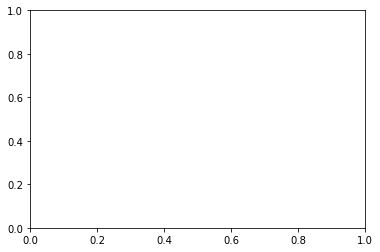